# Moount google drive to colab

In [ ]:
from google.colab import drive
drive.mount("/content/drive")

Mounted at /content/drive


# Import libraries

In [ ]:
import os
import random 
import numpy as np
import shutil
import time 
from PIL import Image, ImageOps
import cv2
import pandas as pd
import math
from math import floor

import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('darkgrid')

import tensorflow as tf

from sklearn.metrics import confusion_matrix, classification_report
from sklearn.preprocessing import LabelBinarizer
from sklearn.preprocessing import MinMaxScaler
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import EarlyStopping
from keras.callbacks import ModelCheckpoint
from keras.callbacks import LearningRateScheduler

from keras import models, layers, optimizers
from keras.callbacks import ModelCheckpoint
from keras import losses


In [ ]:
ls

drive/  sample_data/


In [ ]:
cd content

/content


# Initialize basic working directories

In [ ]:
directory = "drive/MyDrive/Datasets/Sign digits/Dataset"
trainDir = "train"
testDir = "test"
os.chdir(directory)

# Import data

In [ ]:
# initialize the data and labels
print("[INFO] loading images...")
time1 = time.time()   # to measure time taken
dataTrain = []
dataTest = []
dataVal = []
labelsTrain = []
labelsTest = []
labelsVal = []
testSize = []
valSize = []

for cls in range(0,10):

  dataClass = str(cls)
  test_dir = "augmented/test/"+str(cls)
  train_dir = "augmented/train/"+str(cls)
  
  # keep a list of all image names of train and test set
  imagesTrain = os.listdir(train_dir)
  imagesTest = os.listdir(test_dir)
 
  
  for i in range(len(imagesTrain)):

    # open all train images one by one
    image = np.array(ImageOps.grayscale(Image.open(train_dir + '/' + imagesTrain[i])))
    #image = np.array(Image.open(train_dir + '/' + imagesTrain[i]))
    image = image.flatten()
    if (len(image.tolist())) > 30000:
       continue
    # keep all image flattened arrays in a list
    dataTrain.append(image)
    # add label
    labelsTrain.append(str(cls))

  testSize = [i for i in range(floor(len(imagesTest)/2),len(imagesTest))]
  valSize = [i for i in range(0,floor(len(imagesTest)/2))]

  # same thing for test set
  for i in testSize:

    image = np.array(ImageOps.grayscale(Image.open(test_dir + '/' + imagesTest[i])))
    #image = np.array(Image.open(test_dir + '/' + imagesTest[i]))
    image = image.flatten()
    if (len(image.tolist())) > 30000:
       continue
    dataTest.append(image)
    labelsTest.append(str(cls))

  # same thing for validation set
  for i in valSize:

    image = np.array(ImageOps.grayscale(Image.open(test_dir + '/' + imagesTest[i])))
    #image = np.array(Image.open(test_dir + '/' + imagesTest[i]))
    image = image.flatten()
    if (len(image.tolist())) > 30000:
       continue
    dataVal.append(image)
    labelsVal.append(str(cls))
      
  
  print('ok' + str(cls))
  print('class '+ str(cls) + str(len(dataTrain)))
  print('class '+ str(cls) + str(len(dataTest)))
  print('class '+ str(cls) + str(len(dataVal)))

  # scale the raw pixel intensities to the range [0, 1]

  augmentedTrainX = np.array(dataTrain) 
  augmentedValX = np.array(dataVal) 
  augmentedTestX = np.array(dataTest) 
  augmentedTrainY = np.array(labelsTrain)
  augmentedTestY = np.array(labelsTest)
  augmentedValY = np.array(labelsVal)

print('Type of trainX and testX: ' + str(type(augmentedTrainX)))
print('Shape of trainX array: ' + str(augmentedTrainX.shape))
print('dataTest shape: ' + str(len(dataTest)))
print('Time taken: {:.1f} seconds'.format(time.time() - time1))   # to measure time taken
print("[INFO] Images are loaded.")


[INFO] loading images...
ok0
class 0310
class 027
class 027
ok1
class 1622
class 152
class 152
ok2
class 2934
class 277
class 277
ok3
class 31246
class 3102
class 3102
ok4
class 41560
class 4127
class 4127
ok5
class 51874
class 5152
class 5152
ok6
class 62188
class 6177
class 6177
ok7
class 72496
class 7202
class 7201
ok8
class 82812
class 8227
class 8226
ok9
class 93120
class 9252
class 9251
Type of trainX and testX: <class 'numpy.ndarray'>
Shape of trainX array: (3120, 10000)
dataTest shape: 252
Time taken: 8.3 seconds
[INFO] Images are loaded.


In [ ]:
lb = LabelBinarizer()
augmentedTrainY = lb.fit_transform(augmentedTrainY)   
augmentedValY = lb.transform(augmentedValY) 
augmentedTestY = lb.transform(augmentedTestY) 
augmentedTrainY

/usr/local/lib/python3.7/dist-packages/numpy/lib/arraysetops.py:580: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


array([[1, 0, 0, ..., 0, 0, 0],
       [1, 0, 0, ..., 0, 0, 0],
       [1, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 1],
       [0, 0, 0, ..., 0, 0, 1],
       [0, 0, 0, ..., 0, 0, 1]], dtype=int64)

In [ ]:
scalerTrain = MinMaxScaler(feature_range=(-1, 1))
augmented_NormalizedTrainX = augmentedTrainX
scalerTrain.fit(augmented_NormalizedTrainX)
augmented_NormalizedTrainX = scalerTrain.transform(augmented_NormalizedTrainX)

scalerTest = MinMaxScaler(feature_range=(-1, 1))
augmented_NormalizedValX = augmentedValX
scalerTest.fit(augmented_NormalizedValX)
augmented_NormalizedValX = scalerTest.transform(augmented_NormalizedValX)

scalerTest = MinMaxScaler(feature_range=(-1, 1))
augmented_NormalizedTestX = augmentedTestX
scalerTest.fit(augmented_NormalizedTestX)
augmented_NormalizedTestX = scalerTest.transform(augmented_NormalizedTestX)

In [ ]:
model = models.Sequential()

model.add(tf.keras.Input(shape=(10000)))
model.add(layers.Dense(1024,activation='relu',kernel_regularizer=tf.keras.regularizers.l1(0.001)))
model.add(layers.BatchNormalization())
model.add(layers.Dense(512,activation='relu'))
model.add(layers.BatchNormalization())
model.add(layers.Dense(128,activation='relu'))
model.add(layers.BatchNormalization())
model.add(layers.Dense(64,activation='relu'))
model.add(layers.Dropout(0.6))
model.add(layers.Dense(10, activation='softmax'))

model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_5 (Dense)              (None, 1024)              10241024  
_________________________________________________________________
batch_normalization_3 (Batch (None, 1024)              4096      
_________________________________________________________________
dense_6 (Dense)              (None, 512)               524800    
_________________________________________________________________
batch_normalization_4 (Batch (None, 512)               2048      
_________________________________________________________________
dense_7 (Dense)              (None, 128)               65664     
_________________________________________________________________
batch_normalization_5 (Batch (None, 128)               512       
_________________________________________________________________
dense_8 (Dense)              (None, 64)               

In [ ]:
# Compile the model
model.compile(loss="categorical_crossentropy", optimizer = 'adam', metrics=["accuracy"])

# Learning scheduler function
def step_decay(epoch):
	initial_lrate = 1e-3
	drop = 0.5
	epochs_drop = 5
	lrate = initial_lrate * math.pow(drop, math.floor((epoch)/epochs_drop))
	return lrate

# Train the model
# Consider callbacks
mc = ModelCheckpoint('best_model.h5', monitor='val_accuracy', mode='max', verbose=1, save_best_only=True)
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=5)
lr = LearningRateScheduler(step_decay)

history = model.fit(
      augmented_NormalizedTrainX,
      augmentedTrainY,
      epochs=80,
      validation_data=(augmented_NormalizedValX,augmentedValY),
      verbose=1, callbacks = [ es, mc, lr])

Epoch 1/80
98/98 [==============================] - 2s 10ms/step - loss: 83.3750 - accuracy: 0.2792 - val_loss: 18.4542 - val_accuracy: 0.2789

Epoch 00001: val_accuracy improved from -inf to 0.27888, saving model to best_model.h5
Epoch 2/80
98/98 [==============================] - 1s 8ms/step - loss: 16.7415 - accuracy: 0.5084 - val_loss: 16.4710 - val_accuracy: 0.3187

Epoch 00002: val_accuracy improved from 0.27888 to 0.31873, saving model to best_model.h5
Epoch 3/80
98/98 [==============================] - 1s 8ms/step - loss: 15.0758 - accuracy: 0.5366 - val_loss: 17.9728 - val_accuracy: 0.1315

Epoch 00003: val_accuracy did not improve from 0.31873
Epoch 4/80
98/98 [==============================] - 1s 8ms/step - loss: 14.6763 - accuracy: 0.5742 - val_loss: 15.4511 - val_accuracy: 0.2908

Epoch 00004: val_accuracy did not improve from 0.31873
Epoch 5/80
98/98 [==============================] - 1s 8ms/step - loss: 14.1678 - accuracy: 0.6299 - val_loss: 16.4624 - val_accuracy: 0.243

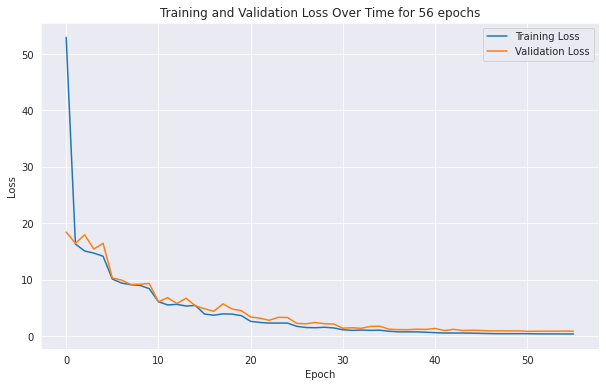

In [ ]:
plt.figure(figsize=(10, 6))

epochs_range = range(len(history.history['loss']))

plt.plot(epochs_range, history.history['loss'], label="Training Loss")
plt.plot(epochs_range, history.history['val_loss'], label="Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.title("Training and Validation Loss Over Time for 56 epochs")
plt.show()

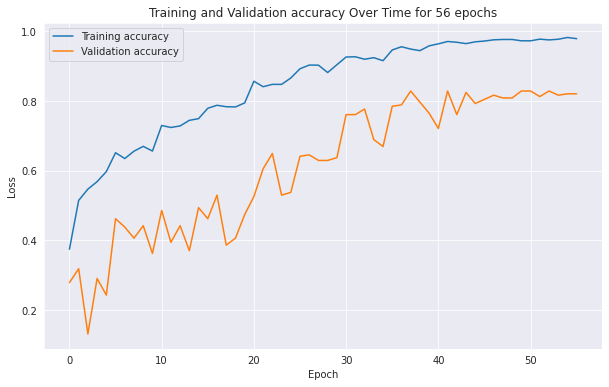

In [ ]:
plt.figure(figsize=(10, 6))

epochs_range = range(len(history.history['accuracy']))

plt.plot(epochs_range, history.history['accuracy'], label="Training accuracy")
plt.plot(epochs_range, history.history['val_accuracy'], label="Validation accuracy")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.title("Training and Validation accuracy Over Time for 56 epochs")
plt.show()

In [ ]:
def evaluate_model(model, X_test, y_test_oneHot, labels):
    
    labels = np.array(labels)
    labels = labels.astype(int)
    
    y_pred = np.argmax(model.predict(X_test), axis=1)
    
    
    cm = confusion_matrix(labels, y_pred)
    clr = classification_report(labels, y_pred)
    
    plt.figure(figsize=(10, 10))
    sns.heatmap(cm, annot=True, vmin=0, fmt='g', cmap='Blues', cbar=False)
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.title("Confusion Matrix")
    plt.show()
    
    print("Classification Report:\n----------------------\n", clr)


In [ ]:
model.save('best_ever_ANN.h5')

In [ ]:
model.load_weights('best_model.h5')


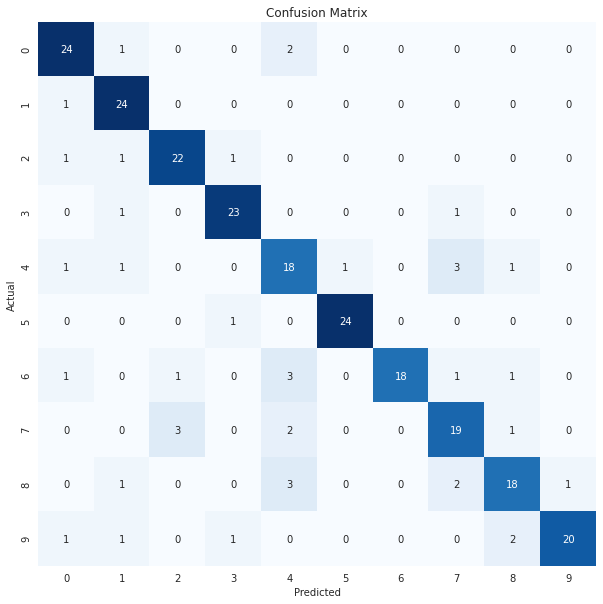

Classification Report:
----------------------
               precision    recall  f1-score   support

           0       0.83      0.89      0.86        27
           1       0.80      0.96      0.87        25
           2       0.85      0.88      0.86        25
           3       0.88      0.92      0.90        25
           4       0.64      0.72      0.68        25
           5       0.96      0.96      0.96        25
           6       1.00      0.72      0.84        25
           7       0.73      0.76      0.75        25
           8       0.78      0.72      0.75        25
           9       0.95      0.80      0.87        25

    accuracy                           0.83       252
   macro avg       0.84      0.83      0.83       252
weighted avg       0.84      0.83      0.83       252



In [ ]:
evaluate_model(model, augmented_NormalizedTestX, augmentedTestY, labelsTest)